In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_from_disk
ds = load_from_disk('/content/drive/MyDrive/Georgia-Tech/DL-Final')
train_dataset = ds['train']

In [ ]:
!pip install torchcodec

In [ ]:
train_dataset[0]['audio']['array']

array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
       -0.00317383, -0.00418091], dtype=float32)

In [ ]:
import IPython.display as ipd
ipd.Audio(data=train_dataset[0]["audio"]["array"], autoplay=True, rate=16000)

In [ ]:
from datasets import load_from_disk, Audio
from torch.utils.data import Dataset

In [ ]:
ds_split = train_dataset.train_test_split(test_size=0.1)
train_dataset = ds_split["train"]
eval_dataset = ds_split["test"]
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16000))
eval_dataset = eval_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Dict, Any, List
from datasets import load_from_disk, Audio
from torch.utils.data import Dataset
from transformers import (
    Wav2Vec2Model,
    Wav2Vec2Config,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2PreTrainedModel,
    TrainingArguments,
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, f1_score
from dataclasses import dataclass
from typing import Optional, Union, Dict, Any

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

emotion_list = [
    "frustrated", "angry", "sad", "disgust",
    "excited", "fear", "neutral", "surprise", "happy"
]
NUM_EMOTIONS = len(emotion_list)
MODEL_CHECKPOINT = "facebook/wav2vec2-large"

Using device: cuda


In [ ]:
class IEMOCAPAudioDataset(Dataset):
    def __init__(self, hf_ds, threshold=0.05):
        self.ds = hf_ds
        self.threshold = threshold
        # The new target list of 6 classes
        self.merged_emotion_list = [
            "angry",          # (angry + frustrated)
            "happy",          # (happy + excited)
            "sad",            # (sad)
            "neutral",        # (neutral)
            "fear_surprise",  # (fear + surprise)
            "disgust"         # (disgust)
        ]

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        audio_array = item["audio"]["array"]

        # Sum the raw votes/probabilities for the merged pairs
        raw_angry = float(item.get("angry", 0)) + float(item.get("frustrated", 0))
        raw_happy = float(item.get("happy", 0)) + float(item.get("excited", 0))
        raw_sad   = float(item.get("sad", 0))
        raw_neutral = float(item.get("neutral", 0))
        raw_fear_surp = float(item.get("fear", 0)) + float(item.get("surprise", 0))
        raw_disgust = float(item.get("disgust", 0))

        # Create the new raw vector (Size 6)
        new_label_vec = torch.tensor(
            [raw_angry, raw_happy, raw_sad, raw_neutral, raw_fear_surp, raw_disgust],
            dtype=torch.float32
        )

        # Zero out any merged probability below the threshold
        mask = new_label_vec >= self.threshold
        new_label_vec = new_label_vec * mask.float()

        # Ensure the vector sums to 1.0 (Soft Label Requirement)
        if new_label_vec.sum() > 0:
            new_label_vec = new_label_vec / new_label_vec.sum()
        else:
            # Fallback if everything was below threshold (rare, but prevents NaN)
            # Uniform distribution or keep as zeros (KLDiv requires sum=1 usually)
            new_label_vec = torch.ones_like(new_label_vec) / len(new_label_vec)

        # Return inputs and SOFT labels (float tensor)
        return {"input_values": audio_array, "labels": new_label_vec}




# --- Feature Extractor and Data Collator ---
processor = Wav2Vec2FeatureExtractor.from_pretrained(
    MODEL_CHECKPOINT,
    return_attention_mask=True
)

# --- CORRECTED DataCollatorSER ---
@dataclass
class DataCollatorSER:
    processor: Wav2Vec2FeatureExtractor

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:

        input_values_list = [f["input_values"] for f in features]
        batch = self.processor(
            input_values_list,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )

        labels = torch.stack([f["labels"] for f in features])

        batch["input_values"] = batch["input_values"].float()

        batch["labels"] = labels.float()
        return batch

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Wav2Vec2PreTrainedModel, Wav2Vec2Model
from transformers.modeling_outputs import SequenceClassifierOutput

class MultiHeadAttentionPoolingHead(nn.Module):
    """
    True Multi-Head Attention Pooling.
    Uses a single linear projection to compute 'num_heads' attention distributions simultaneously.
    """
    def __init__(self, hidden_dim, num_labels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim

        self.attn = nn.Linear(hidden_dim, num_heads)

        self.output_proj = nn.Linear(hidden_dim * num_heads, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.LayerNorm(256, eps=1e-5),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(256, num_labels),
        )

        self.context_norm = nn.LayerNorm(hidden_dim, eps=1e-5)

    def forward(self, hidden_states, attention_mask=None):
        B, T, D = hidden_states.size()

        attn_logits = self.attn(hidden_states)

        if attention_mask is not None:
            mask = attention_mask.float().unsqueeze(-1)
            attn_logits = attn_logits.masked_fill(mask == 0, -1e4)

        attn_weights = F.softmax(attn_logits, dim=1) # [B, T, H]
        attn_weights = torch.nan_to_num(attn_weights, nan=0.0)

        context_heads = torch.einsum('btd, bth -> bhd', hidden_states, attn_weights)

        context_flat = context_heads.reshape(B, self.num_heads * D)

        context = self.output_proj(context_flat)
        context = self.context_norm(context)

        logits = self.classifier(context)

        return logits



class Wav2Vec2ForSER(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.num_labels = config.num_labels
        self.wav2vec2 = Wav2Vec2Model(config)

        self.classifier = MultiHeadAttentionPoolingHead(
            hidden_dim=config.hidden_size,
            num_labels=config.num_labels,
            num_heads=4
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)
        self.loss_fct = nn.KLDivLoss(reduction='batchmean')

        self.post_init()
        self.freeze_layers(12)

    def freeze_layers(self, n):
        self.wav2vec2.feature_extractor._freeze_parameters()
        for layer in self.wav2vec2.encoder.layers[:n]:
            for p in layer.parameters():
                p.requires_grad = False
        print(f"Frozen CNN + bottom {n} transformer layers")

    def forward(self, input_values, attention_mask=None, labels=None):

        outputs = self.wav2vec2(
            input_values=input_values,
            attention_mask=attention_mask,
        )
        hidden_states = outputs.last_hidden_state  # [B, T', D]

        projected_mask = None
        if attention_mask is not None:
            projected_mask = self.wav2vec2._get_feature_vector_attention_mask(
                hidden_states.shape[1],
                attention_mask
            ).to(hidden_states.device).float()

        logits = self.classifier(hidden_states, projected_mask)

        loss = None
        if labels is not None:
            log_probs = self.log_softmax(logits)
            loss = self.loss_fct(log_probs, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
from transformers import Trainer

class DifferentialTrainer(Trainer):
    def create_optimizer(self):
        """
        Setup the optimizer with different learning rates for the backbone and head.
        """
        if self.optimizer is not None:
            return self.optimizer

        head_params = list(self.model.classifier.parameters())
        backbone_params = list(self.model.wav2vec2.parameters())

        backbone_params = [p for p in backbone_params if p.requires_grad]

        optimizer_grouped_parameters = [
            {
                "params": head_params,
                "lr": 5e-4,
            },
            {
                "params": backbone_params,
                "lr": 1e-5,
            }
        ]

        self.optimizer = torch.optim.AdamW(
            optimizer_grouped_parameters,
            weight_decay=self.args.weight_decay,
        )

        return self.optimizer

In [ ]:
train_set = IEMOCAPAudioDataset(train_dataset, threshold=0.05)
eval_set = IEMOCAPAudioDataset(eval_dataset, threshold=0.05)
data_collator = DataCollatorSER(processor=processor)

emotion_list = ["angry", "happy", "sad", "neutral", "fear_surprise", "disgust"]
NUM_EMOTIONS = len(emotion_list)

config = Wav2Vec2Config.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_EMOTIONS,
    label2id={e: i for i, e in enumerate(emotion_list)},
    id2label={i: e for i, e in enumerate(emotion_list)}
)

model = Wav2Vec2ForSER.from_pretrained(MODEL_CHECKPOINT, config=config)
model.to(device)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    pred_ids = np.argmax(predictions, axis=1)
    true_ids = np.argmax(labels, axis=1)

    top_1_accuracy = accuracy_score(true_ids, pred_ids)
    macro_f1 = f1_score(true_ids, pred_ids, average="macro", zero_division=0)

    top_2_indices = np.argsort(predictions, axis=1)[:, -2:]
    true_ids_expanded = true_ids[:, np.newaxis]

    is_correct_top_2 = np.any(top_2_indices == true_ids_expanded, axis=1)

    top_2_accuracy = np.mean(is_correct_top_2)

    return {
        "accuracy": top_1_accuracy,
        "macro_f1": macro_f1,
        "top_2_accuracy": top_2_accuracy,
    }



training_args = TrainingArguments(
    output_dir="./wav2vec2-iemocap-ser-differential",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,

    num_train_epochs=10,
    warmup_ratio=0.1,

    learning_rate=3e-5,

    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    save_total_limit=2,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    remove_unused_columns=False,
    report_to="none"
)

trainer = DifferentialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


print("\nStarting Wav2Vec2 Fine-Tuning for IEMOCAP SER...")
trainer.train()

Frozen CNN + bottom 12 transformer layers


Some weights of Wav2Vec2ForSER were not initialized from the model checkpoint at facebook/wav2vec2-large and are newly initialized: ['classifier.attn.bias', 'classifier.attn.weight', 'classifier.classifier.0.bias', 'classifier.classifier.0.weight', 'classifier.classifier.1.bias', 'classifier.classifier.1.weight', 'classifier.classifier.4.bias', 'classifier.classifier.4.weight', 'classifier.context_norm.bias', 'classifier.context_norm.weight', 'classifier.output_proj.bias', 'classifier.output_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting Wav2Vec2 Fine-Tuning for IEMOCAP SER...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Top 2 Accuracy
1,0.845300,0.841523,0.529880,0.328391,0.754980
2,0.800400,0.758942,0.571713,0.395073,0.795817
3,0.754000,0.944980,0.564741,0.344372,0.774900
4,0.693100,0.688005,0.634462,0.469703,0.826693
5,0.650200,0.726985,0.625498,0.468876,0.835657
6,0.624600,0.760230,0.627490,0.452248,0.830677
7,0.562300,0.682191,0.651394,0.519045,0.842629
8,0.582900,0.725072,0.630478,0.480575,0.851594
9,0.548900,0.667877,0.652390,0.541453,0.842629
10,0.543000,0.679281,0.649402,0.506138,0.851594


TrainOutput(global_step=5650, training_loss=0.6692173527405325, metrics={'train_runtime': 3092.4308, 'train_samples_per_second': 29.216, 'train_steps_per_second': 1.827, 'total_flos': 2.161038058213413e+19, 'train_loss': 0.6692173527405325, 'epoch': 10.0})

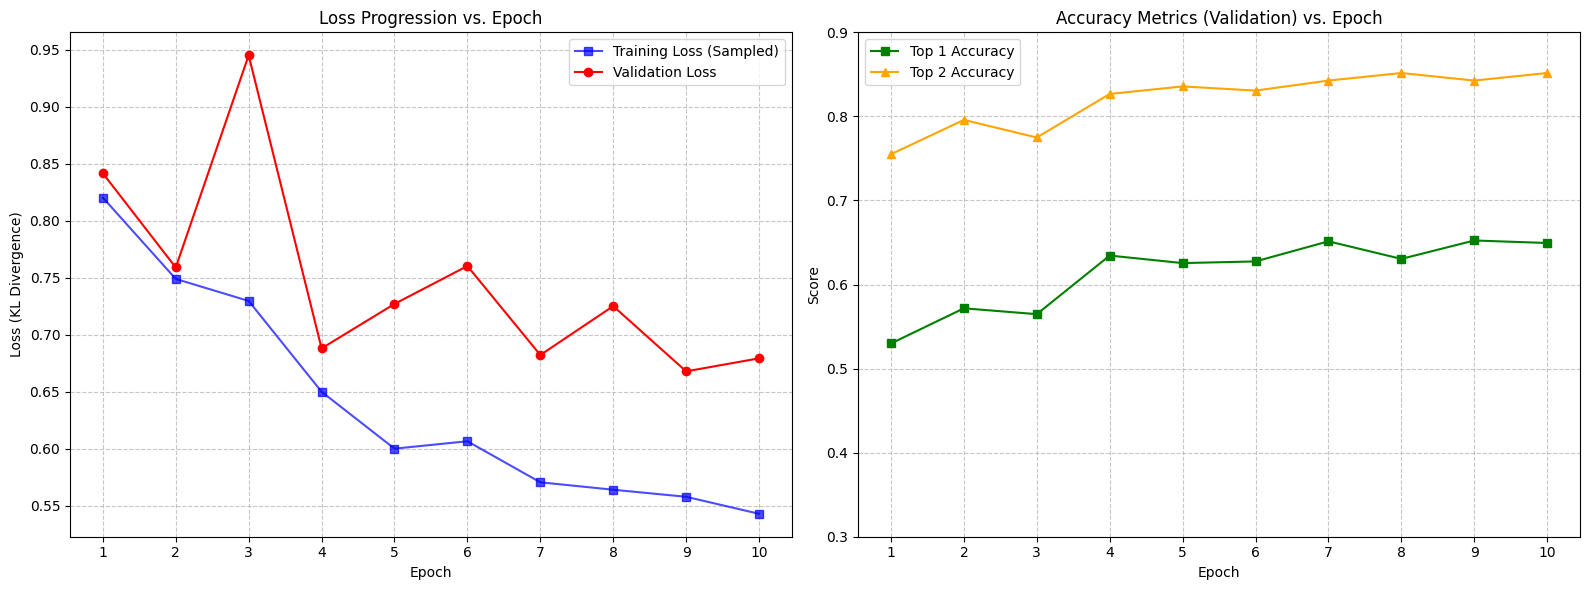

Combined plot saved as combined_accuracy_metrics_zoomed.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

log_history = trainer.state.log_history

eval_losses = []
eval_accuracies = []
eval_top2_accuracies = []
eval_f1_scores = []
epochs_eval = []
train_losses_per_epoch = {}

for log in log_history:
    epoch = log.get('epoch')

    if 'eval_loss' in log:
        epochs_eval.append(epoch)
        eval_losses.append(log['eval_loss'])
        eval_accuracies.append(log['eval_accuracy'])
        eval_top2_accuracies.append(log['eval_top_2_accuracy'])
        eval_f1_scores.append(log['eval_macro_f1'])

    if 'loss' in log and epoch is not None:
        rounded_epoch = round(epoch)
        train_losses_per_epoch[rounded_epoch] = log['loss']

train_loss_values = []
for epoch in epochs_eval:
    rounded_epoch = round(epoch)
    if rounded_epoch in train_losses_per_epoch:
        train_loss_values.append(train_losses_per_epoch[rounded_epoch])
    else:
        train_loss_values.append(np.nan)

valid_indices = ~np.isnan(train_loss_values)
epochs_eval_filtered = np.array(epochs_eval)[valid_indices]
eval_losses_filtered = np.array(eval_losses)[valid_indices]
train_loss_values_filtered = np.array(train_loss_values)[valid_indices]
eval_accuracies_filtered = np.array(eval_accuracies)[valid_indices]
eval_top2_accuracies_filtered = np.array(eval_top2_accuracies)[valid_indices]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))


ax1 = axes[0]
ax1.plot(epochs_eval_filtered, train_loss_values_filtered, label='Training Loss (Sampled)', color='blue', marker='s', alpha=0.7)
ax1.plot(epochs_eval_filtered, eval_losses_filtered, label='Validation Loss', color='red', marker='o')

ax1.set_title('Loss Progression vs. Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (KL Divergence)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(np.unique([round(e) for e in epochs_eval_filtered]))



ax2 = axes[1]
ax2.plot(epochs_eval_filtered, eval_accuracies_filtered, label='Top 1 Accuracy', color='green', marker='s')
ax2.plot(epochs_eval_filtered, eval_top2_accuracies_filtered, label='Top 2 Accuracy', color='orange', marker='^')

ax2.set_title('Accuracy Metrics (Validation) vs. Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')

ax2.set_ylim(0.3, 0.9)

ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticks(np.unique([round(e) for e in epochs_eval_filtered]))

plt.tight_layout()
plt.savefig('combined_accuracy_metrics_zoomed.png')
plt.show()

print("Combined plot saved as combined_accuracy_metrics_zoomed.png")

In [ ]:
from transformers.trainer_utils import PredictionOutput
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

print("Generating predictions on the evaluation set...")
prediction_output: PredictionOutput = trainer.predict(eval_set)

logits = prediction_output.predictions

soft_labels = prediction_output.label_ids

probabilities = torch.softmax(torch.tensor(logits), dim=-1).numpy()

predicted_indices = np.argmax(probabilities, axis=1)

ground_truth_indices = np.argmax(soft_labels, axis=1)

predicted_emotions = [emotion_list[i] for i in predicted_indices]

true_emotions = [emotion_list[i] for i in ground_truth_indices]

print("\n--- Sample Prediction Output ---")
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  True Emotion:     {true_emotions[i]}")
    print(f"  Predicted Emotion:{predicted_emotions[i]}")
    emotion_probs = {e: round(p, 4) for e, p in zip(emotion_list, probabilities[i])}
    print(f"  Probabilities:    {emotion_probs}")
print("--------------------------------\n")

print("--- Classification Report ---")
print(classification_report(
    ground_truth_indices,
    predicted_indices,
    target_names=emotion_list,
    labels=list(range(len(emotion_list)))
))

# Confusion matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(
    ground_truth_indices,
    predicted_indices,
    labels=list(range(len(emotion_list)))
)
print(cm)

Generating predictions on the evaluation set...



--- Sample Prediction Output ---
Sample 1:
  True Emotion:     neutral
  Predicted Emotion:angry
  Probabilities:    {'angry': np.float32(0.3556), 'happy': np.float32(0.2523), 'sad': np.float32(0.0416), 'neutral': np.float32(0.3036), 'fear_surprise': np.float32(0.0373), 'disgust': np.float32(0.0096)}
Sample 2:
  True Emotion:     happy
  Predicted Emotion:happy
  Probabilities:    {'angry': np.float32(0.0097), 'happy': np.float32(0.9432), 'sad': np.float32(0.003), 'neutral': np.float32(0.0154), 'fear_surprise': np.float32(0.0277), 'disgust': np.float32(0.0009)}
Sample 3:
  True Emotion:     neutral
  Predicted Emotion:angry
  Probabilities:    {'angry': np.float32(0.817), 'happy': np.float32(0.0088), 'sad': np.float32(0.0053), 'neutral': np.float32(0.1361), 'fear_surprise': np.float32(0.0191), 'disgust': np.float32(0.0137)}
Sample 4:
  True Emotion:     neutral
  Predicted Emotion:neutral
  Probabilities:    {'angry': np.float32(0.1817), 'happy': np.float32(0.2113), 'sad': np.float32(

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me